In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
gpu = True

In [5]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [6]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [7]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 10))
fixed_data, _ = next(iter(test_loader))
if gpu:
    fixed_z = fixed_z.to(device)
    fixed_data = fixed_data.to(device)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh, flatten=False):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma

        self.fce = FullyConnected([784, 512, 128, latent_size*2], activation_fn=nn.ReLU, flatten=True)
        self.fcd = FullyConnected([latent_size, 128, 512, 784], activation_fn=nn.ReLU)
        
        self._loss = None
        if gpu:
            self.to(device)
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def encode(self, x):
        h = self.fce(x)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = torch.tanh(self.fcd(h))
        x = flatten.view(-1, 1, 28, 28)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            res = self._sample(mu.shape[0])
            if gpu:
                res = res.to(device)
            h = res * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [10]:
models = {'VAE10': Net(10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        if gpu:
            data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [12]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            if gpu:
                data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.cpu().numpy()
            fixed_gen = models[k].decode(fixed_z).data.cpu().numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9344
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.2656
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.2392
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.2081
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.1963
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.1881


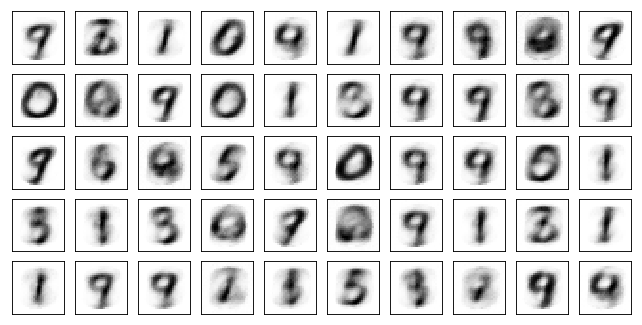

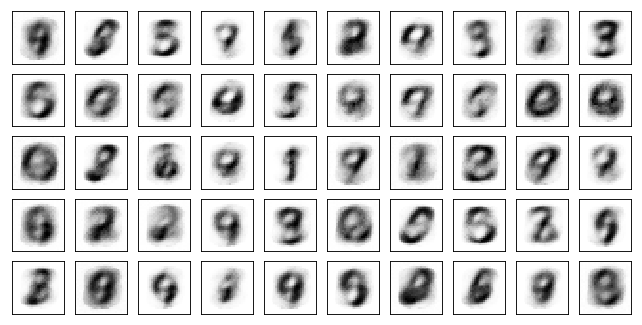

Test losses: VAE10: 0.1665/5.8505
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.1820
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.1773
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.1675
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.1548
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.1631
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.1396


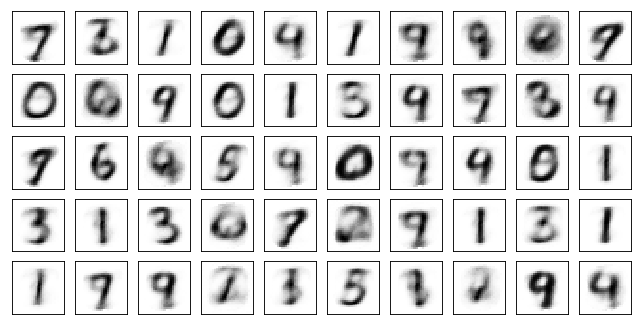

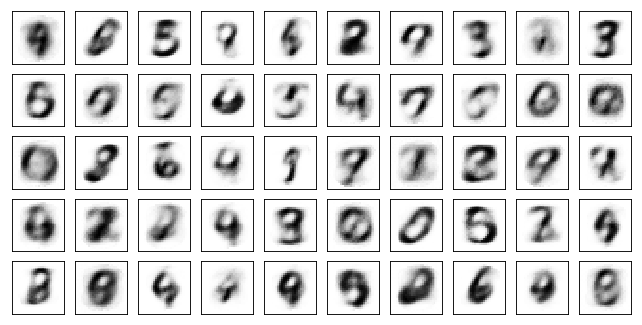

Test losses: VAE10: 0.1334/7.5453
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.1390
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1444
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.1450
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1420
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1503
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1108


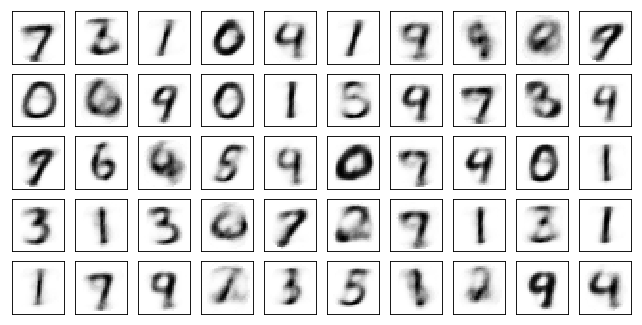

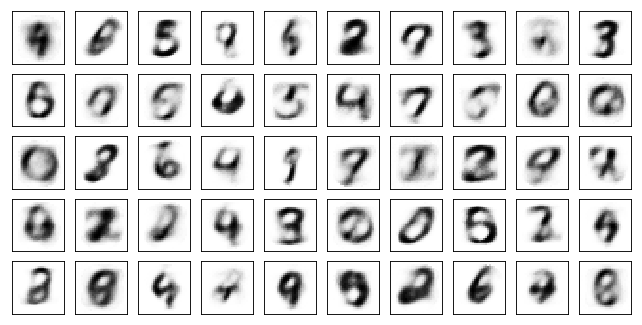

Test losses: VAE10: 0.1179/8.4230
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1410
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1271
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1289
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1203
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1306
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1212


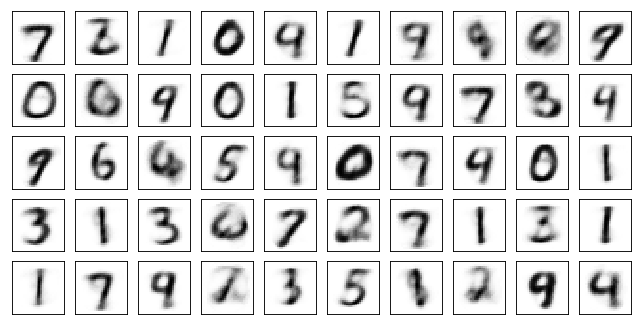

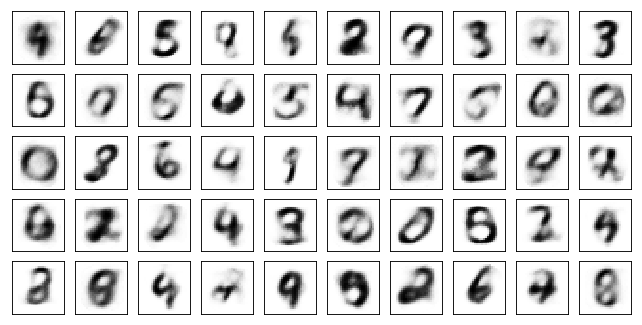

Test losses: VAE10: 0.1081/8.9355
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1155
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1278
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1210
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1262
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1262
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1192


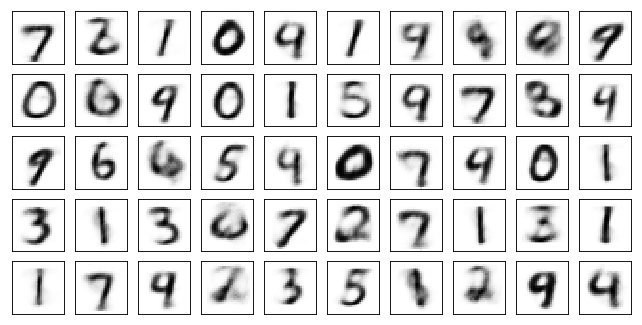

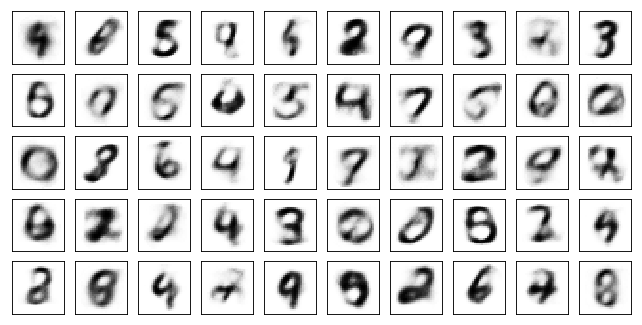

Test losses: VAE10: 0.1022/9.4767
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1276
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1132
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1237
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1129
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1153
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1153


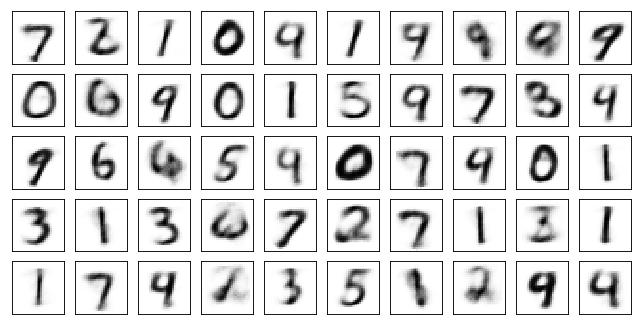

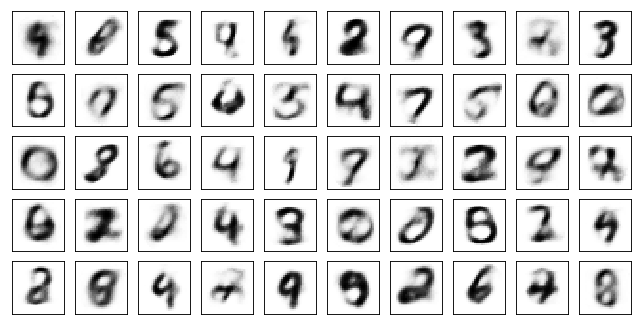

Test losses: VAE10: 0.0975/9.5223
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1166
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1189
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1044
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1318
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1213
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1111


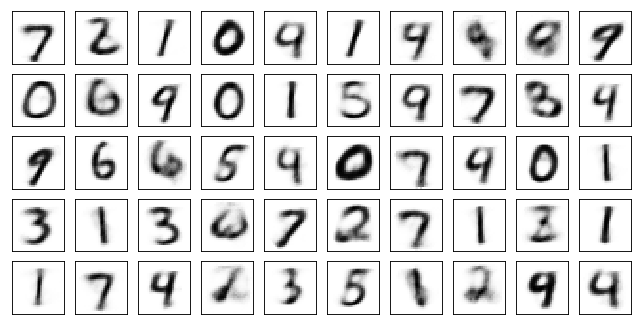

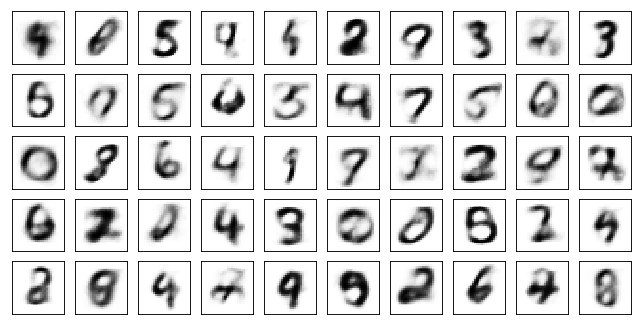

Test losses: VAE10: 0.0938/9.6896
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1192
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1205
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1150
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1179
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1122
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1090


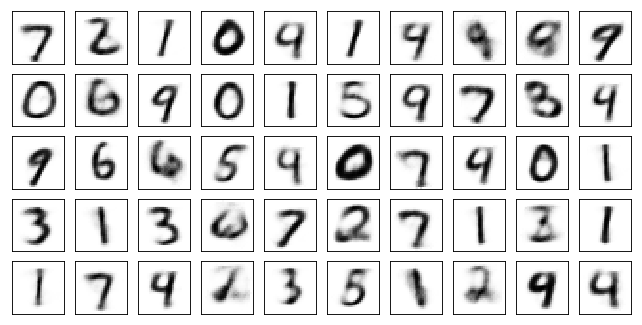

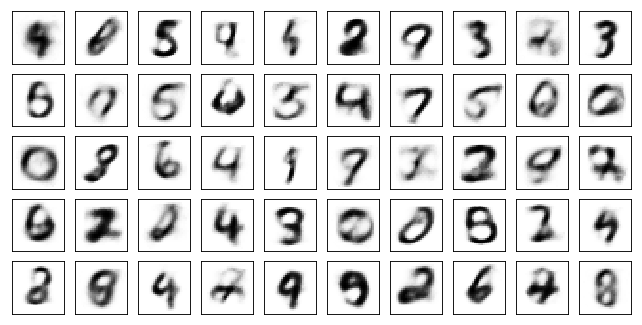

Test losses: VAE10: 0.0911/10.2115
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1033
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1126
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1109
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1101
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1003
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1089


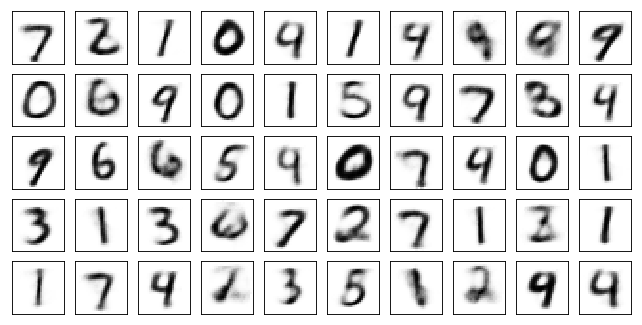

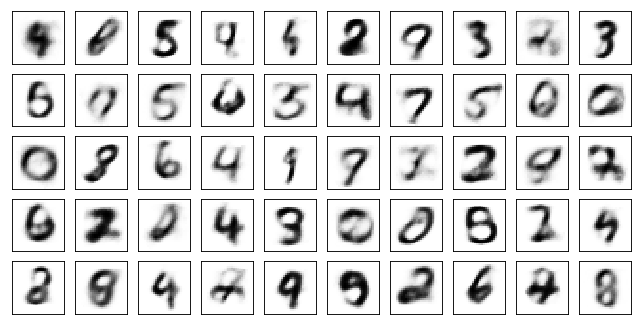

Test losses: VAE10: 0.0889/9.8978
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1095
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1104
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1158
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1034
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.0953
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1091


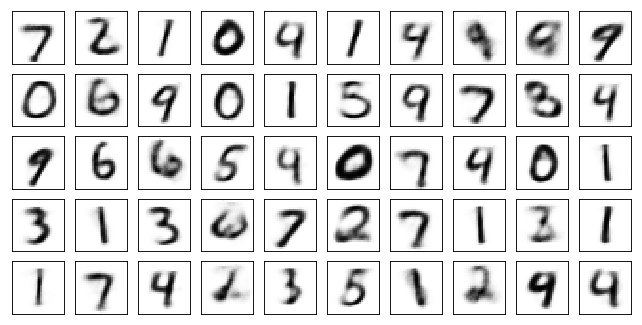

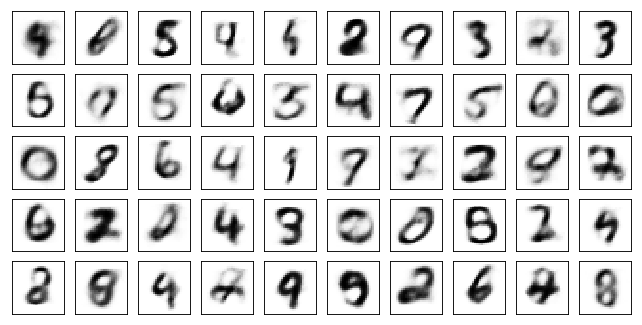

Test losses: VAE10: 0.0870/10.1828
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1135
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1060
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.0984
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.1085
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1133
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.0984


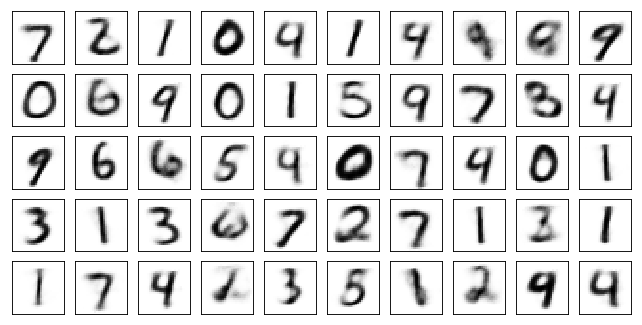

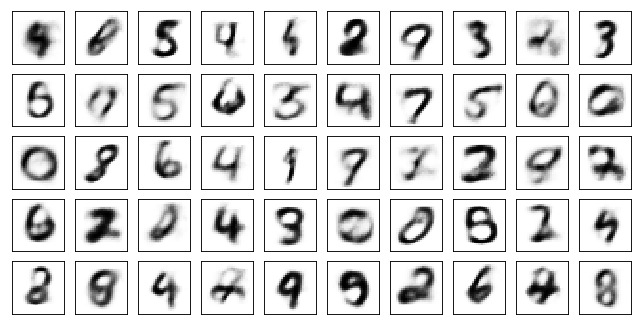

Test losses: VAE10: 0.0855/10.1810
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1130
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1006
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1085
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1070
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.1003
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.0997


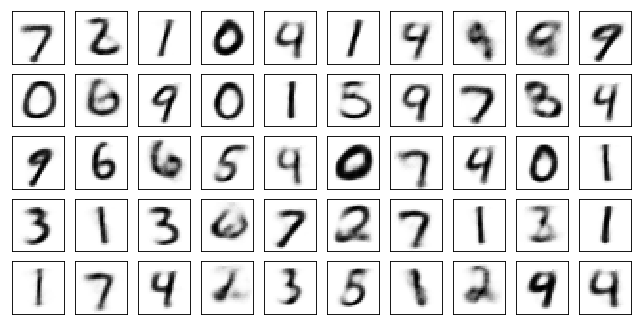

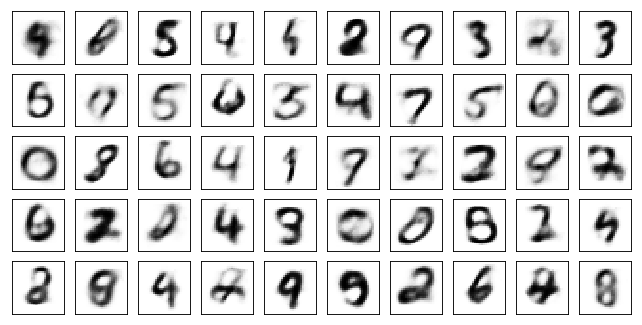

Test losses: VAE10: 0.0836/10.3370
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1020
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1008
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.0960
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1044
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.1115
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1040


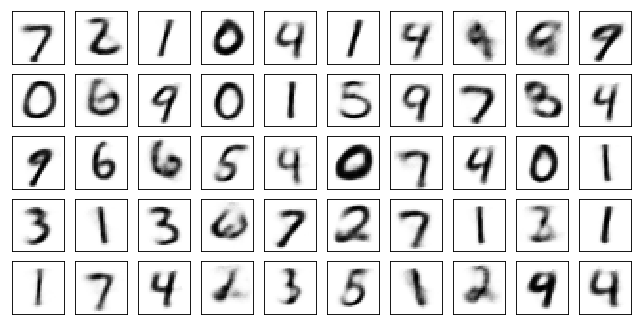

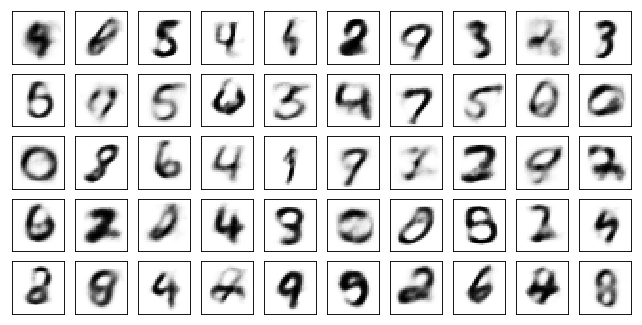

Test losses: VAE10: 0.0824/10.2511
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.0984
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.0917
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1046
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1063
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.0967
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1014


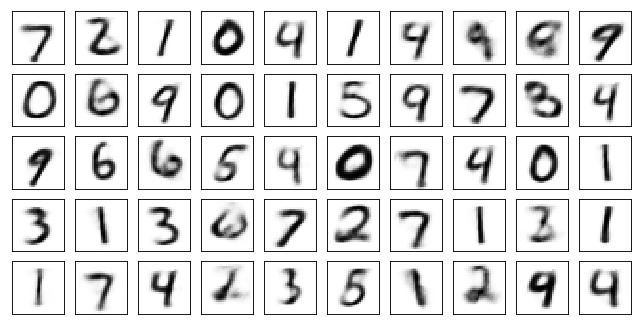

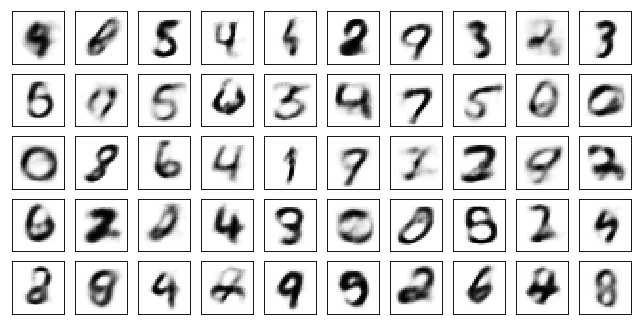

Test losses: VAE10: 0.0811/10.3032
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.1193
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.1028
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1013
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.0922
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.0994
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.1008


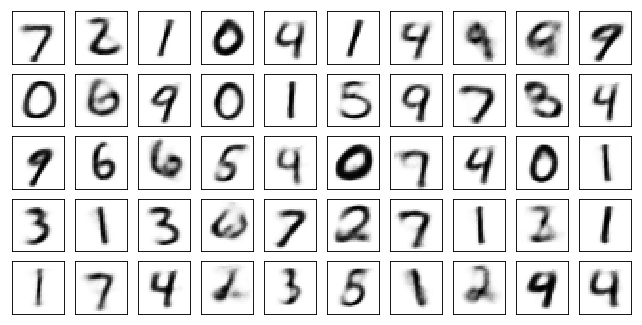

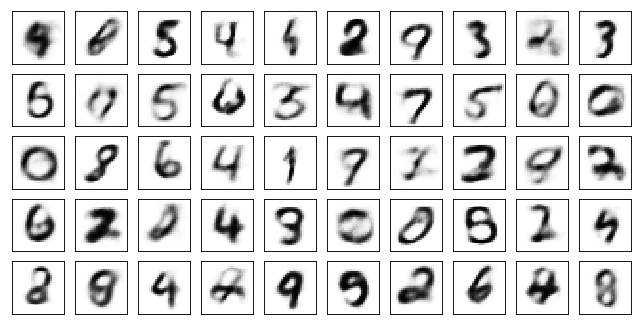

Test losses: VAE10: 0.0798/10.7873
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.0993
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.0994
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.0863
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.1005
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.1004
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.0808


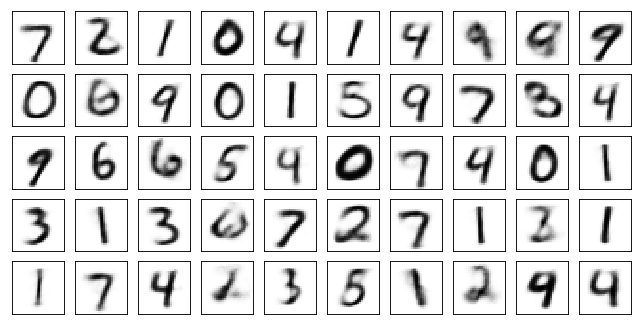

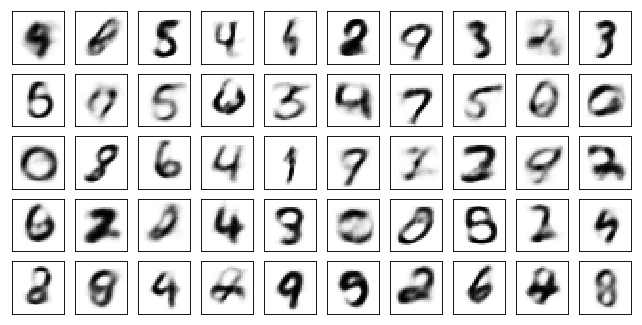

Test losses: VAE10: 0.0788/10.5739
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.0879
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1034
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.1040
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1034
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.1008
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1053


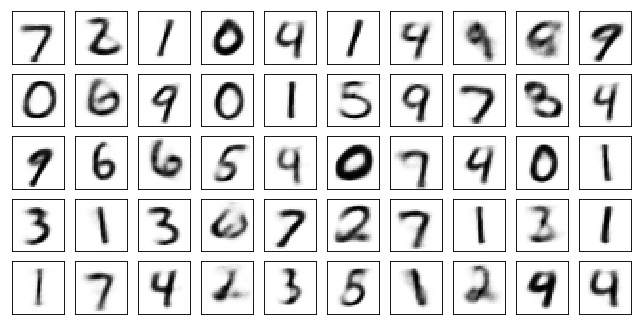

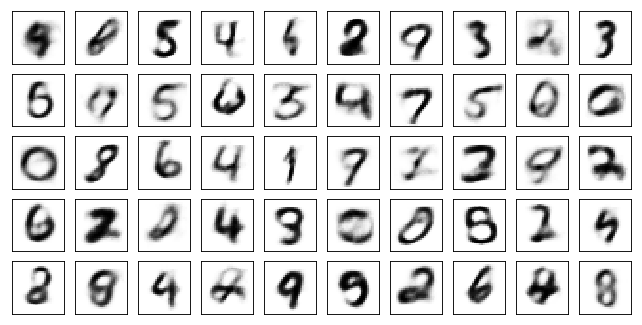

Test losses: VAE10: 0.0777/10.7959
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.0970
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.0900
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.1050
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.0983
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.0969
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.0994


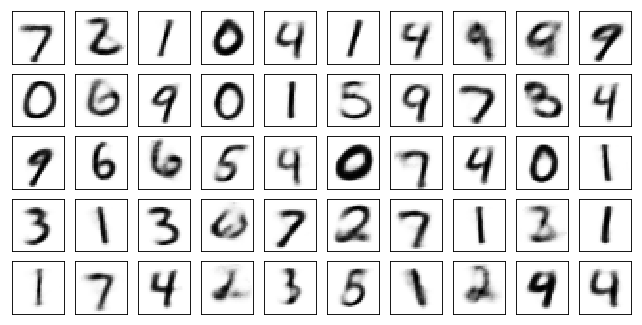

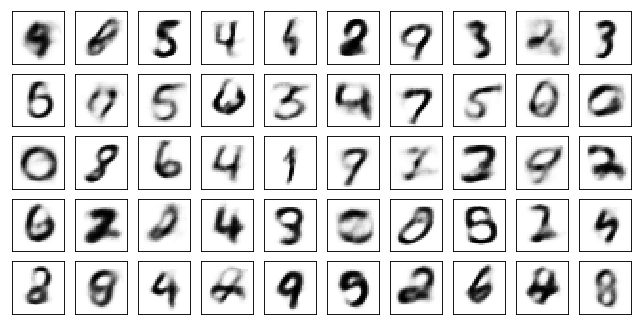

Test losses: VAE10: 0.0771/10.5178
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.0945
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.0968
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1082
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.0960
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.0998
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.0933


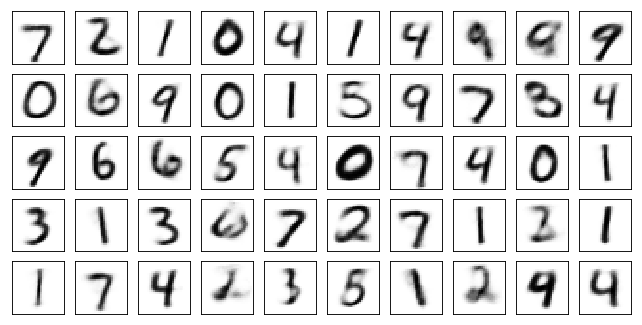

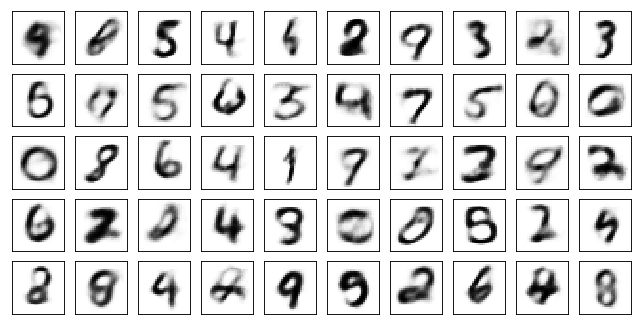

Test losses: VAE10: 0.0770/10.6747
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1010
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.1079
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.0984
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.1111
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.0986
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.0888


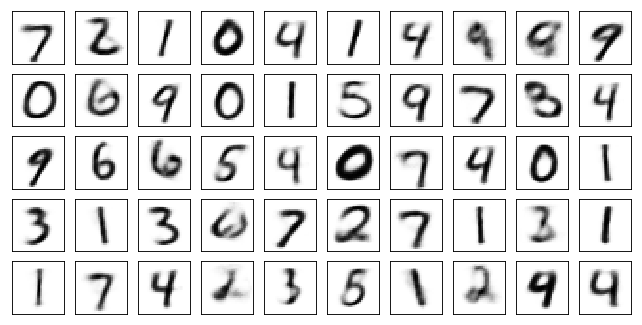

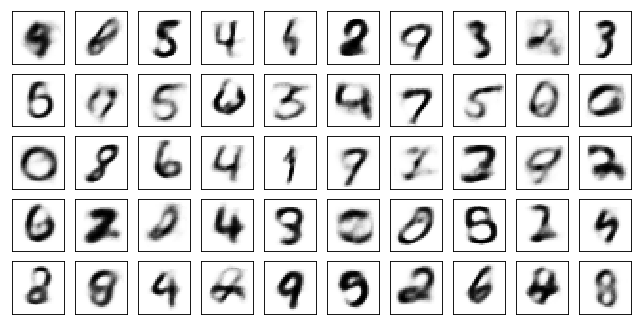

Test losses: VAE10: 0.0759/10.6883
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.0941
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.0889
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.0962
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.0869
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.0872
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.0867


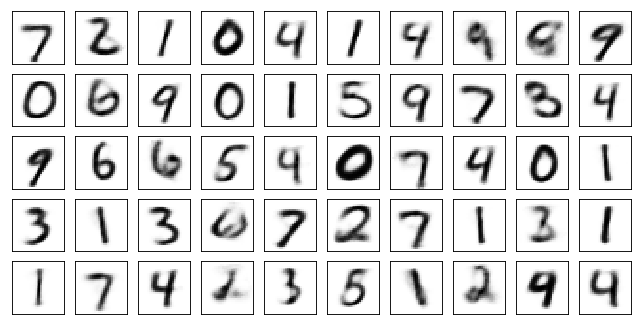

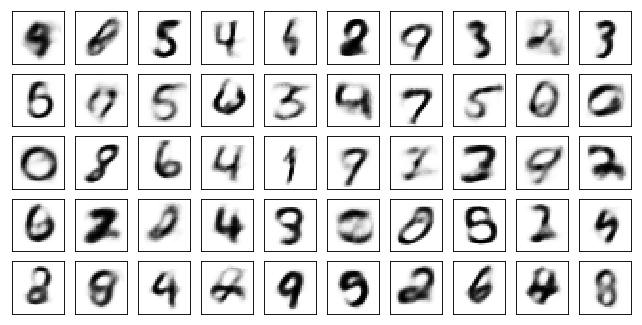

Test losses: VAE10: 0.0751/10.5618
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.0888
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.1114
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.0924
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.0943
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.0902
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.0965


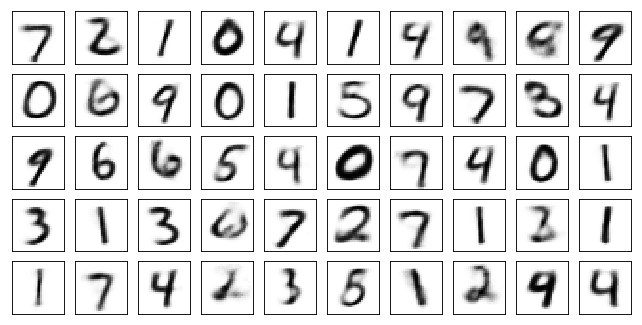

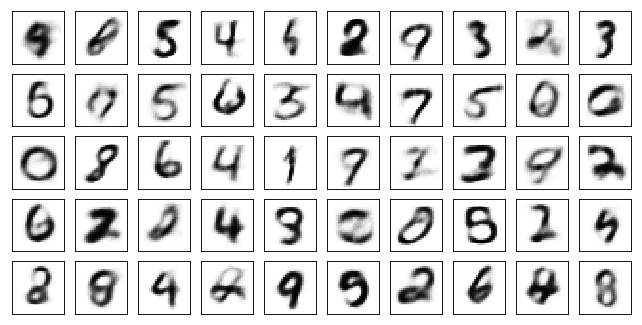

Test losses: VAE10: 0.0740/10.9590
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.0946
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.0877
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.0832
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.0974
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.0978
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.0935


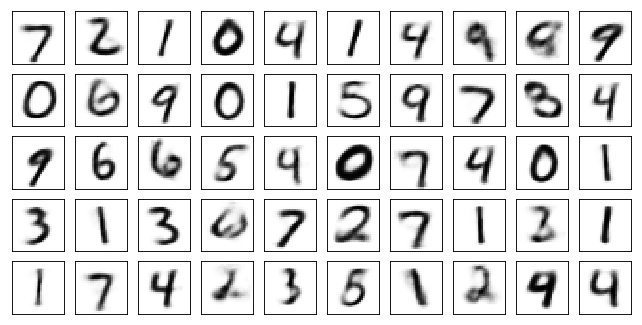

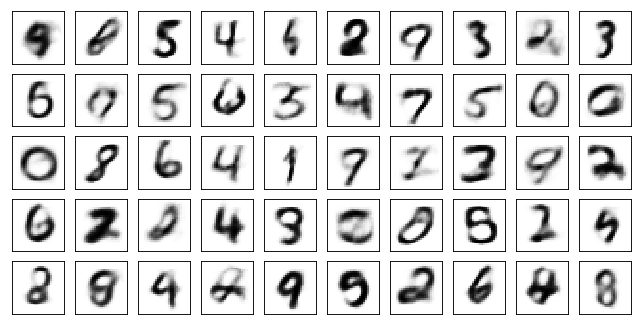

Test losses: VAE10: 0.0737/10.7581
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.0890
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.0931
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.0904
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.0936
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.0892
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.1011


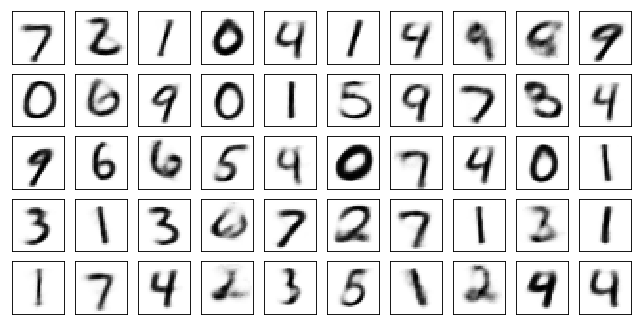

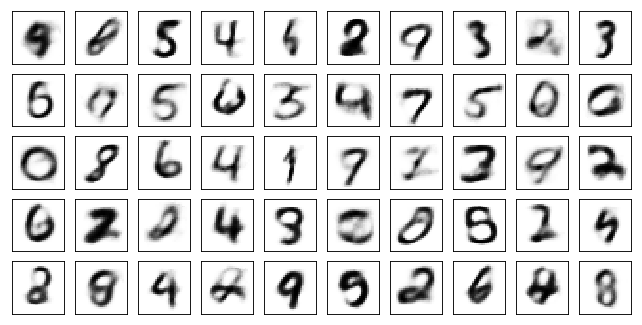

Test losses: VAE10: 0.0729/11.1447
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.0869
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.0965
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.0869
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE10: 0.0939
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE10: 0.0942
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE10: 0.0859


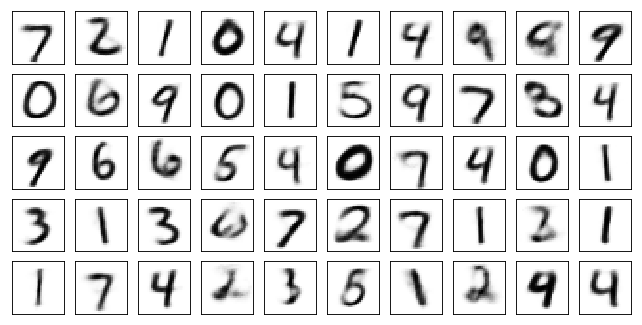

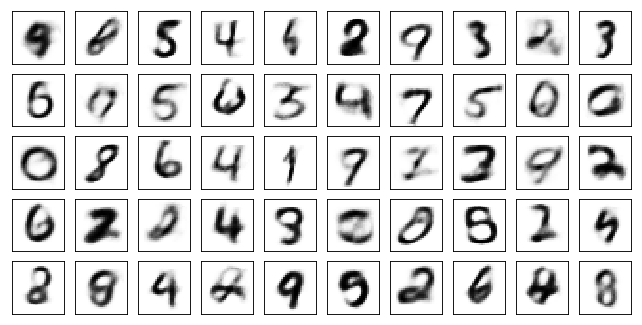

Test losses: VAE10: 0.0727/10.9469
Train Epoch: 26 [0/50000 (0%)]	Losses VAE10: 0.0948
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE10: 0.0904
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE10: 0.0872
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE10: 0.0973
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE10: 0.0984
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE10: 0.0917


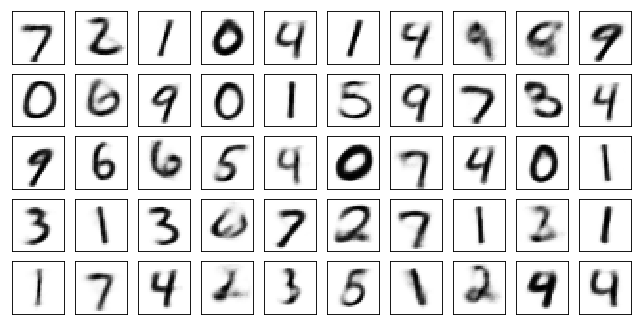

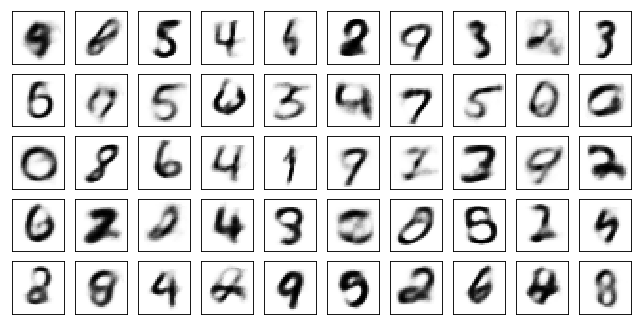

Test losses: VAE10: 0.0719/11.0317
Train Epoch: 27 [0/50000 (0%)]	Losses VAE10: 0.0885
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE10: 0.0949
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE10: 0.0872
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE10: 0.0928
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE10: 0.0991
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE10: 0.0954


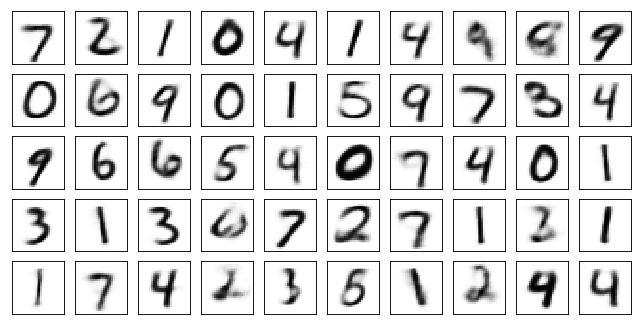

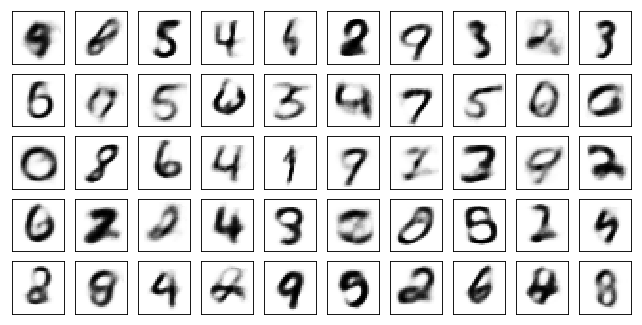

Test losses: VAE10: 0.0719/10.9628
Train Epoch: 28 [0/50000 (0%)]	Losses VAE10: 0.0902
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE10: 0.0846
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE10: 0.0845
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE10: 0.0786
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE10: 0.0928
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE10: 0.0869


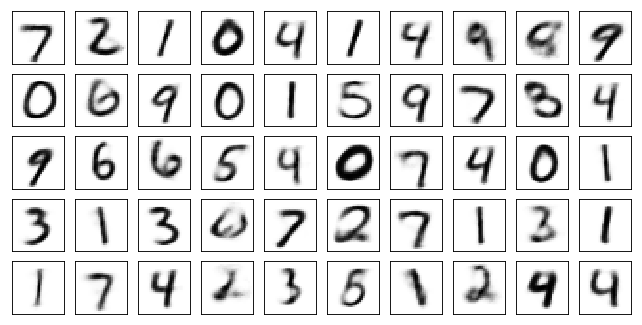

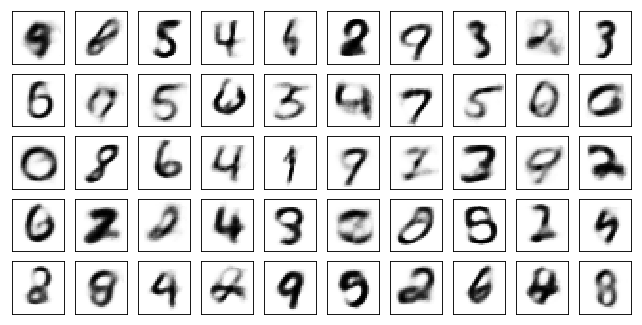

Test losses: VAE10: 0.0719/11.1246
Train Epoch: 29 [0/50000 (0%)]	Losses VAE10: 0.0944
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE10: 0.0903
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE10: 0.0898
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE10: 0.1005
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE10: 0.0885
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE10: 0.0939


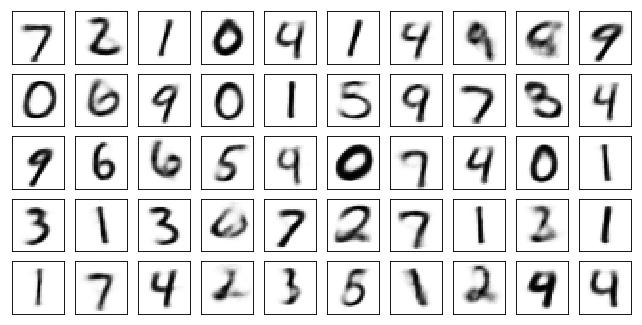

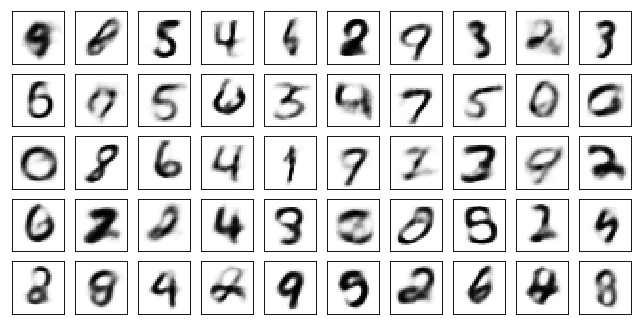

Test losses: VAE10: 0.0710/11.1023
Train Epoch: 30 [0/50000 (0%)]	Losses VAE10: 0.0943
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE10: 0.0814
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE10: 0.0929
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE10: 0.0975
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE10: 0.0973
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE10: 0.0921


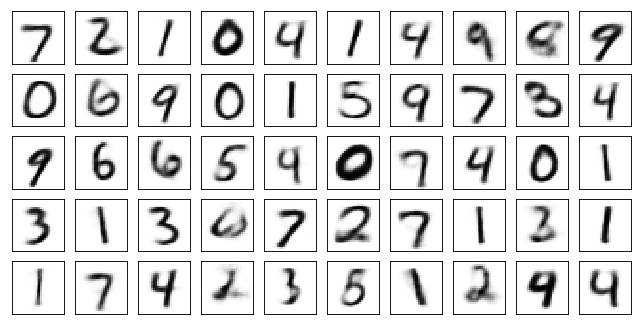

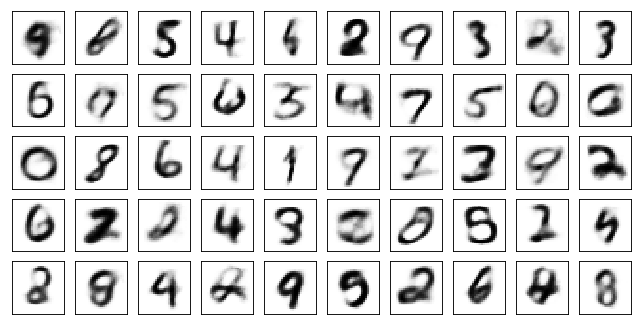

Test losses: VAE10: 0.0705/10.9571


In [13]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)